In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import sys

### Carregando número de ligações por município

In [2]:
df_n_ligacoes = pd.read_csv('/home/breno/projects/sobre-rodas/data/raw/Ligações por Municipio.csv')
df_n_ligacoes = df_n_ligacoes.rename(columns={'COUNT(1)': 'NUM_LIGACOES'})
print(df_n_ligacoes.info())
print(df_n_ligacoes.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   CD_MUNICIPIO  203 non-null    int64
 1   NUM_LIGACOES  203 non-null    int64
dtypes: int64(2)
memory usage: 3.3 KB
None
   CD_MUNICIPIO  NUM_LIGACOES
0           511         17915
1           512         14080
2           522         54697
3           513          9027
4           722           625


### Carregando informações de limpeza

In [3]:
df_limpezas = pd.read_csv('/home/breno/projects/sobre-rodas/data/raw/V_LIMPEZAS_EXECUTADAS_202510141706.csv')  
print(df_limpezas.info())
print(df_limpezas.head())   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CD_MUNICIPIO   249 non-null    int64 
 1   DATA_EXECUCAO  249 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.0+ KB
None
   CD_MUNICIPIO            DATA_EXECUCAO
0           571  2025-07-01 14:46:05.000
1           571  2024-11-06 09:09:50.000
2           571  2024-11-05 11:21:39.000
3           571  2024-12-11 14:56:06.000
4           571  2024-11-27 09:28:24.000


### Carregando informações de município

In [4]:
df_municipios = pd.read_csv('/home/breno/projects/sobre-rodas/data/raw/ORGAO_EMPRESA_202510141615.csv')
df_municipios = df_municipios.rename(columns={'CD_ORGAO_EMPRESA': 'CD_MUNICIPIO', 'NM_ORGAO_EMPRESA': 'NM_MUNICIPIO'})
print(df_municipios.info())
print(df_municipios.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473 entries, 0 to 472
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CD_MUNICIPIO  473 non-null    int64 
 1   NM_MUNICIPIO  473 non-null    object
dtypes: int64(1), object(1)
memory usage: 7.5+ KB
None
   CD_MUNICIPIO        NM_MUNICIPIO
0             1              MATRIZ
1             2              ITAJAÍ
2             3  BALNEÁRIO CAMBORIU
3             4       FLORIANÓPOLIS
4             5             TUBARÃO


### Calculando número de limpezas por município

In [5]:
# 1. Agrupar pelo código do município e contar
df_contagem_limpezas = (
    df_limpezas
    .groupby('CD_MUNICIPIO')
    .size()
    .reset_index(name='NUM_LIMPEZAS') # Renomeia a coluna de contagem para 'NUM_LIMPEZAS'
)

# Exibe o novo DataFrame com a contagem de limpezas por município
df_contagem_limpezas

,CD_MUNICIPIO,NUM_LIMPEZAS
0,571,249


### Calculando limpezas por ligação

In [6]:
# 1. Merge df_municipios com df_n_ligacoes (usando 'left' para manter todos os municípios e nomes)
df_final = pd.merge(
    df_municipios,
    df_n_ligacoes,
    on='CD_MUNICIPIO',
    how='left'
)

# 2. Merge o resultado com df_contagem_limp
df_final = pd.merge(
    df_final,
    df_contagem_limpezas,
    on='CD_MUNICIPIO',
    how='left'
)

# 3. Criar a nova coluna 'LIMPEZAS_LIGACOES'
# Divisão de limpezas por ligações.
df_final['LIMPEZAS_LIGACOES'] = df_final['NUM_LIMPEZAS'] / df_final['NUM_LIGACOES']

# 4. **FILTRAGEM:** Apenas municípios que tenham limpeza realizada.
# Consideramos limpeza realizada se NUM_LIMPEZAS não for NaN E for maior que zero.
df_final = df_final[df_final['NUM_LIMPEZAS'].notna() & (df_final['NUM_LIMPEZAS'] > 0)].copy()

# 5. Selecionar e ordenar as colunas finais
df_final = df_final[[
    'CD_MUNICIPIO',
    'NM_MUNICIPIO',
    'NUM_LIGACOES',
    'NUM_LIMPEZAS',
    'LIMPEZAS_LIGACOES'
]]

df_final

,CD_MUNICIPIO,NM_MUNICIPIO,NUM_LIGACOES,NUM_LIMPEZAS,LIMPEZAS_LIGACOES
288,571,DESCANSO,2131.0,249.0,0.116847


### Plotando número de limpezas por ligação

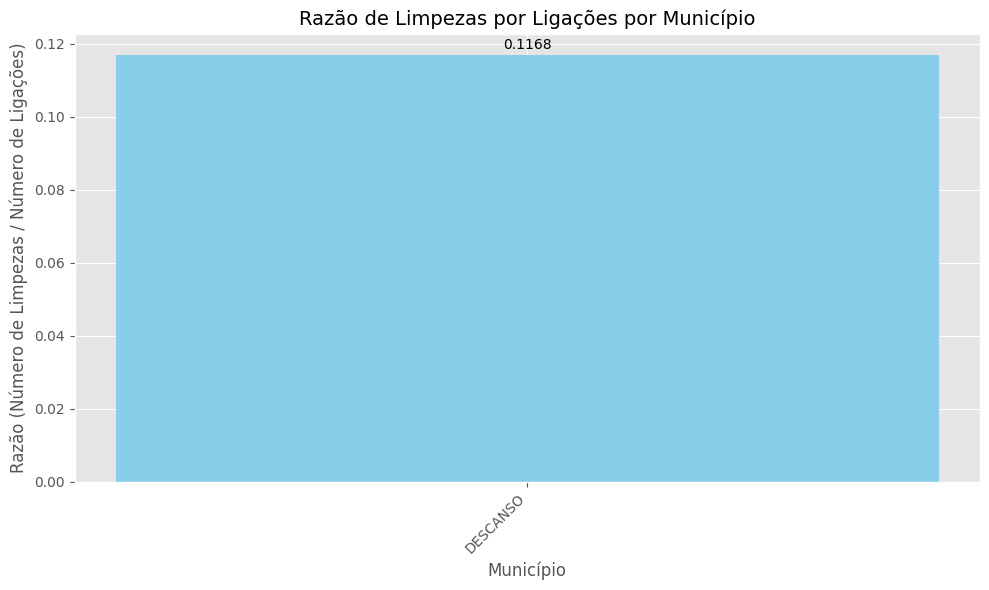

In [7]:
# Geração do Gráfico Matplotlib

# Configuração do estilo
plt.style.use('ggplot')

# Criação da figura e do eixo
fig, ax = plt.subplots(figsize=(10, 6))

# Dados para o gráfico: Razão Limpezas/Ligações por Município
municipios = df_final['NM_MUNICIPIO']
razoes = df_final['LIMPEZAS_LIGACOES']

# Geração do Gráfico de Barras
bars = ax.bar(municipios, razoes, color='skyblue')

# Adicionando Títulos e Rótulos
ax.set_title('Razão de Limpezas por Ligações por Município', fontsize=14)
ax.set_xlabel('Município', fontsize=12)
ax.set_ylabel('Razão (Número de Limpezas / Número de Ligações)', fontsize=12)

# Rotação dos rótulos do eixo X para melhor visualização
plt.xticks(rotation=45, ha='right')

# Adicionando rótulos de valor em cima das barras (formatado com 4 casas decimais)
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.001, round(yval, 4), ha='center', va='bottom', fontsize=10)

# Ajuste do layout para evitar cortes
plt.tight_layout()

# Salvar o gráfico
plt.savefig('razao_limpezas_ligacoes.png')

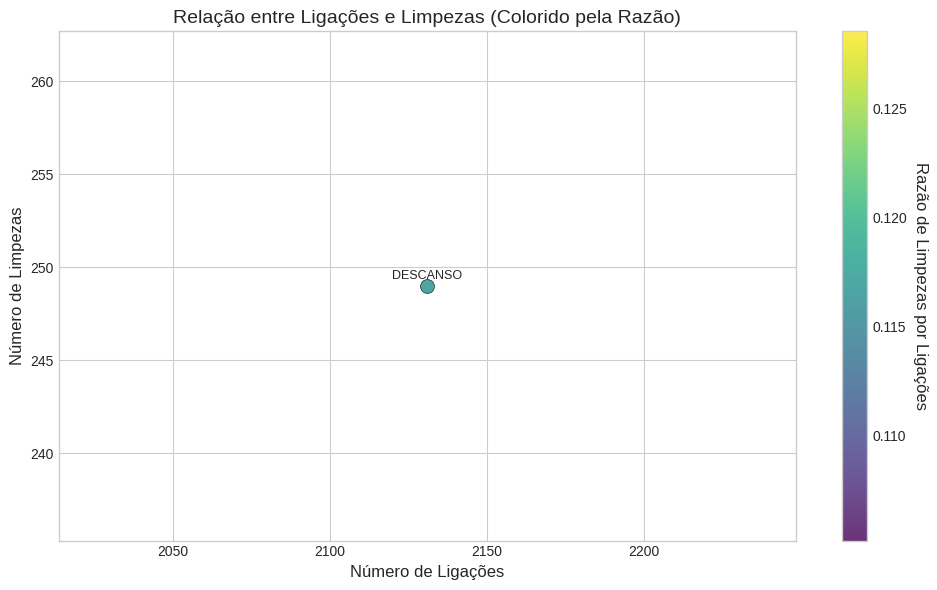

In [8]:
# Configuração do estilo
plt.style.use('seaborn-v0_8-whitegrid')

# Criação da figura e do eixo
fig, ax = plt.subplots(figsize=(10, 6))

# Dados para o gráfico Scatter:
x_data = df_final['NUM_LIGACOES']
y_data = df_final['NUM_LIMPEZAS']
color_data = df_final['LIMPEZAS_LIGACOES'] # Usado para colorir os pontos

# Geração do Gráfico Scatter
scatter = ax.scatter(
    x_data,
    y_data,
    c=color_data,             # Define a cor baseada na razão
    cmap='viridis',           # Mapa de cores (cores mais escuras = maior razão)
    s=100,                    # Tamanho fixo dos pontos
    alpha=0.8,                # Transparência
    edgecolors='k'            # Contorno preto
)

# Adicionando Títulos e Rótulos
ax.set_title('Relação entre Ligações e Limpezas (Colorido pela Razão)', fontsize=14)
ax.set_xlabel('Número de Ligações', fontsize=12)
ax.set_ylabel('Número de Limpezas', fontsize=12)

# Adicionando a barra de cores (Colorbar) para interpretar as cores
cbar = fig.colorbar(scatter)
cbar.set_label('Razão de Limpezas por Ligações', rotation=270, labelpad=15)

# Adicionando rótulos aos pontos com o nome do município (útil para conjuntos de dados menores)
for i, row in df_final.iterrows():
    ax.annotate(row['NM_MUNICIPIO'], (row['NUM_LIGACOES'], row['NUM_LIMPEZAS']), 
                textcoords="offset points", xytext=(0, 5), ha='center', fontsize=9)


# Ajuste do layout para evitar cortes
plt.tight_layout()

# Exibir/Salvar o gráfico
plt.savefig('scatter_limpezas_ligacoes.png')

### Salvando numero de limpezas por ligação no banco de dados

In [9]:
DB_USER = "superset"
DB_PASSWORD = "superset"
DB_HOST = "superset.casan.com.br"
DB_PORT = "5432"
DB_NAME = "sobrerodas"
TABLE_NAME = "limpezas_ligacao"

# --- 2. Criar a Engine de Conexão (SQLAlchemy) ---

DATABASE_URL = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

try:
    engine = create_engine(DATABASE_URL)
    print("Engine de conexão criada com sucesso.")
    
    # --- 3. Gravar o DataFrame na Tabela do PostgreSQL ---
    
    df_final.to_sql(
        name=TABLE_NAME, 
        con=engine, 
        if_exists='replace', # Opções: 'fail', 'replace', 'append'
        index=False          # Não grava o índice do DataFrame como coluna
    )

    print(f"\nDataFrame gravado com sucesso na tabela '{TABLE_NAME}' no banco de dados '{DB_NAME}'.")

except ImportError:
    print("\nERRO: Certifique-se de que os pacotes 'pandas', 'sqlalchemy' e 'psycopg2' estão instalados.")
    print("Execute: pip install pandas sqlalchemy psycopg2")
except Exception as e:
    print(f"\nOCORREU UM ERRO ao tentar conectar ou gravar no banco de dados:")
    print(e)
    # Exibe a linha do erro, se possível
    exc_type, exc_obj, exc_tb = sys.exc_info()
    print(f"Linha do erro: {exc_tb.tb_lineno}")
finally:
    # É uma boa prática descartar a engine no final, embora não seja estritamente necessário 
    # se o script for encerrado logo em seguida.
    if 'engine' in locals():
        engine.dispose()

Engine de conexão criada com sucesso.

DataFrame gravado com sucesso na tabela 'limpezas_ligacao' no banco de dados 'sobrerodas'.
